# EMATM0048 - Part 2: Data Analytics 

# Earthquake Analysis Project

## Introduction
The goal of this project is to perform a comprehensive data analysis using real-world data extracted via an external API. The selected dataset focuses on earthquake events worldwide by the United States Geological Survey (USGS) Earthquake API. This dataset have a lot of features to use for investigating charecteristic of earthquake their potential impacts on tsunami generation. 

The following topics are covered in this Project:
- Step 1: Crawl a real-world datase  
- Step 2: Data Cleaning and Preparation
- Step 3: Perform Exploratory Analysis 
- Step 4: Ask Questions About the Data
- Step 5: Summarize and conclusion

# Step 1: Crawl a real-world datase

### Resource:
- The data of this project come from United States Geological Survey (USGS) Earthquake API, which includes details such as magnitude, depth, location, time, and tsunami alerts. The API is publicly accessible and well-documented, making it a reliable source for scientific research and analysis.

### The variables of interest:

1. Time: The date and time the earthquake occurred (in UTC).
2. Magnitude: The size or intensity of the earthquake.
3. Depth: The depth of the earthquake's epicenter below the Earth's surface (in kilometers).
4. Place: The location or description of where the earthquake occurred.
5. Tsunami Alert: Whether the earthquake triggered a tsunami alert (binary variable: 0 = No, 1 = Yes).
6. Longitude and Latitude: The geographical coordinates of the earthquake's epicenter.

These varibles are important for alalysis between characteristic of earthquake and the possibility of tsunami event.

### How was the data scraped/collected?

The data was collected by using the USGS Earthquake API. The process include the following steps:
1. API Endpoint: The API endpoint used is:
https://earthquake.usgs.gov/fdsnws/event/1/query
This endpoint allows querying earthquake events within a specified time range, magnitude, and other parameters.

2. Parameters:
    - Start Date: January 1, 2013
    - End Date: January 1, 2023
    - Minimum Magnitude: 4.5
    - Format: GeoJSON

3. Data Fetching:
    - Using Python function to fetch data in chunks of one year to avoid exceeding the API's data limits.
    - The data from each chunk was concatenated into a single DataFrame.
    - The function handled errors and ensured the data was collected well.

In [1]:
!pip install requests pandas

In [462]:
import requests
import pandas as pd

# Function to fetch earthquake data for a specific period
def fetch_earthquake_data(start_date, end_date, min_magnitude=4.5):
    url = (
        f"https://earthquake.usgs.gov/fdsnws/event/1/query"
        f"?format=geojson&starttime={start_date}&endtime={end_date}&minmagnitude={min_magnitude}"
    )
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        earthquakes = []
        for feature in data['features']:
            props = feature['properties']
            geom = feature['geometry']['coordinates']
            earthquakes.append({
                "time": pd.to_datetime(props['time'], unit='ms'),
                "magnitude": props['mag'],
                "place": props['place'],
                "longitude": geom[0],
                "latitude": geom[1],
                "depth": geom[2],
                "tsunami_alert": props.get('tsunami', 0),  # Add tsunami alert field
                "alert": props.get('alert', "none")  # Add alert field with default value "none"
            })
        return pd.DataFrame(earthquakes)
    else:
        print(f"Error fetching data: {response.status_code}")
        return None

# Function to fetch data in chunks to avoid API limits
def fetch_data_in_chunks(start_date, end_date, min_magnitude=4.5, chunk_years=1):
    all_data = pd.DataFrame()
    current_start = pd.to_datetime(start_date)
    current_end = current_start + pd.DateOffset(years=chunk_years)

    while current_start < pd.to_datetime(end_date):
        # Ensure current_end does not exceed end_date
        if current_end > pd.to_datetime(end_date):
            current_end = pd.to_datetime(end_date)

        print(f"Fetching data from {current_start.date()} to {current_end.date()}...")
        chunk_data = fetch_earthquake_data(
            current_start.date().isoformat(), current_end.date().isoformat(), min_magnitude
        )
        if chunk_data is not None:
            all_data = pd.concat([all_data, chunk_data], ignore_index=True)

        # Move to the next period
        current_start = current_end
        current_end = current_start + pd.DateOffset(years=chunk_years)

    return all_data

# Set parameters
start_date = "2013-01-01"
end_date = "2023-01-01"
min_magnitude = 4.5

# Fetch all data
earthquake_raw_data = fetch_data_in_chunks(start_date, end_date, min_magnitude, chunk_years=1)

# Check the data and save to CSV
if earthquake_raw_data is not None and not earthquake_raw_data.empty:
    print(f"Data fetched successfully: {len(earthquake_raw_data)} rows")
    print(earthquake_raw_data.head())
    # Save to CSV
    earthquake_raw_data.to_csv("earthquake_raw_data.csv", index=False)
    print("Data saved to 'earthquake_raw_data.csv'")
else:
    print("No data fetched.")

Fetching data from 2013-01-01 to 2014-01-01...
Fetching data from 2014-01-01 to 2015-01-01...
Fetching data from 2015-01-01 to 2016-01-01...
Fetching data from 2016-01-01 to 2017-01-01...
Fetching data from 2017-01-01 to 2018-01-01...
Fetching data from 2018-01-01 to 2019-01-01...
Fetching data from 2019-01-01 to 2020-01-01...
Fetching data from 2020-01-01 to 2021-01-01...
Fetching data from 2021-01-01 to 2022-01-01...
Fetching data from 2022-01-01 to 2023-01-01...
Data fetched successfully: 74369 rows
                     time  magnitude                             place  \
0 2013-12-31 23:41:47.360        5.2   92 km NW of Davila, Philippines   
1 2013-12-31 21:45:54.970        4.8  91 km NNW of Davila, Philippines   
2 2013-12-31 21:32:01.650        5.2  83 km NNW of Davila, Philippines   
3 2013-12-31 20:42:52.420        4.7     Volcano Islands, Japan region   
4 2013-12-31 20:07:43.890        4.9  56 km NNW of Davila, Philippines   

   longitude  latitude  depth  tsunami_alert al

In [482]:
# Load the dataset
earthquake_raw_data = pd.read_csv("earthquake_raw_data.csv")
earthquake_raw_data

,time,magnitude,place,longitude,latitude,depth,tsunami_alert,alert
0,2013-12-31 23:41:47.360,5.2,"92 km NW of Davila, Philippines",120.0807,19.1673,10.28,0,NaN
1,2013-12-31 21:45:54.970,4.8,"91 km NNW of Davila, Philippines",120.1364,19.1828,10.00,0,NaN
2,2013-12-31 21:32:01.650,5.2,"83 km NNW of Davila, Philippines",120.1797,19.1223,10.00,0,NaN
3,2013-12-31 20:42:52.420,4.7,"Volcano Islands, Japan region",143.7362,23.6989,23.99,0,NaN
4,2013-12-31 20:07:43.890,4.9,"56 km NNW of Davila, Philippines",120.3507,18.9341,10.95,0,NaN
...,...,...,...,...,...,...,...,...
74364,2022-01-01 08:14:51.854,4.8,"85 km NE of Yonakuni, Japan",123.4750,25.1059,10.00,0,NaN
74365,2022-01-01 08:08:09.823,5.6,southeast of Easter Island,-100.5380,-36.1658,10.00,0,green
74366,2022-01-01 07:27:57.146,4.6,"73 km NE of Yonakuni, Japan",123.4055,25.0174,10.00,0,NaN
74367,2022-01-01 03:34:34.373,4.6,"98 km ESE of Ozernovskiy, Russia",157.8335,51.1975,68.20,0,NaN


# Step 2: Data Cleaning and Preparation

### Creating a Copy of the DataFrame
- Before starting the data cleaning process, a copy of the original dataset was created. This ensures that the raw data (`earthquake_raw_data`) remains intact. All transformations are performed on the copy (`earthquake_df_copy`), which avoid risks and allows to perform data cleaning and analysis.

In [487]:
# Create DataFrame
earthquake_df_copy = earthquake_raw_data.copy()

### 1. Check and handle for Missing Data
- Missing values in the alert column were replaced with "None Alert" to indicate no alert. Filling missing values to avoid bias.
- Identify missing data by using .isnull().sum() and found missing values in the alert column. This makes sure that dataset have reliability.

In [489]:
# Check the number of Missing Data in alert column
missing_alert_count = earthquake_df['alert'].isnull().sum()
print(f"The number of Missing Data in alert column: {missing_alert_count}")

The number of Missing Data in alert column: 68102


In [493]:
# Replace NaN in 'alert' column by "None Alert"
earthquake_df_copy['alert'].fillna("None Alert", inplace=True)

# Check result
earthquake_df_copy[['alert']].head()  

,alert
0,None Alert
1,None Alert
2,None Alert
3,None Alert
4,None Alert


In [495]:
# Check Missing Data in each column
missing_data = earthquake_df_copy.isnull().sum()
print(missing_data)

# Display only Missing Data
missing_columns = missing_data[missing_data > 0]
print(missing_columns)

time             0
magnitude        0
place            0
longitude        0
latitude         0
depth            0
tsunami_alert    0
alert            0
dtype: int64
Series([], dtype: int64)


In [497]:
# Check in row that have missing D=data
rows_with_missing = earthquake_df_copy[earthquake_df_copy.isnull().any(axis=1)]
print(rows_with_missing)

Empty DataFrame
Columns: [time, magnitude, place, longitude, latitude, depth, tsunami_alert, alert]
Index: []


### 3. Remove Anomalies
- Rows with invalid depth (< 0) or unusually high magnitude (> 10) were removed. 

In [499]:
# Check negative value
invalid_depth = earthquake_df_copy[earthquake_df_copy['depth'] < 0]
print(invalid_depth)

# Check the number of negative value that depth < 0
negative_depth_count = (earthquake_df_copy['depth'] < 0).sum()
print(f"The number of negative value: {negative_depth_count}")

                          time  magnitude                            place  \
40464  2018-07-14 05:08:03.680       5.30       6 km SW of Volcano, Hawaii   
40512  2018-07-11 15:45:53.220       5.30       7 km SW of Volcano, Hawaii   
40620  2018-07-09 19:20:46.280       5.30       7 km SW of Volcano, Hawaii   
40638  2018-07-08 12:54:50.330       5.30       7 km SW of Volcano, Hawaii   
40710  2018-07-03 12:17:03.810       5.30       5 km SW of Volcano, Hawaii   
40729  2018-07-02 11:24:46.190       5.30       7 km SW of Volcano, Hawaii   
40922  2018-06-20 14:22:23.430       5.30      6 km WSW of Volcano, Hawaii   
41124  2018-06-08 12:44:39.650       5.20      6 km WSW of Volcano, Hawaii   
41174  2018-06-05 14:32:34.450       5.40       7 km SW of Volcano, Hawaii   
41285  2018-05-30 20:53:50.830       5.40      6 km WSW of Volcano, Hawaii   
41305  2018-05-29 11:56:11.570       5.30      6 km WSW of Volcano, Hawaii   
53520  2020-08-19 17:32:11.070       4.72  36km WSW of Stovepipe

In [503]:
# Remove the row that depth < 0
earthquake_df_copy = earthquake_df_copy[earthquake_df_copy['depth'] >= 0]

# Check row that have depth < 0 
print(earthquake_df_copy[earthquake_df_copy['depth'] < 0])

# Display the data
print(f"The number of data after remove negative value (depth < 0): {len(earthquake_df_copy)}")

Empty DataFrame
Columns: [time, magnitude, place, longitude, latitude, depth, tsunami_alert, alert]
Index: []
The number of data after remove negative value (depth < 0): 74357


In [180]:
# Check the magnitude value
invalid_magnitude = earthquake_df_copy[earthquake_df_copy['magnitude'] > 10.0]
invalid_magnitude

,time,magnitude,place,longitude,latitude,depth,tsunami_alert,alert


### 4. Transform the time Column
- The time column was converted to datetime format, and additional columns (year, month, day, etc.) were extracted. This may help to explo data in the future.

In [507]:
# Tranform time column to datetime format 
earthquake_df_copy['time'] = pd.to_datetime(earthquake_df_copy['time'])

# Seperate time column to year, month, day, hour, minute, and second 
earthquake_df_copy['year'] = earthquake_df_copy['time'].dt.year
earthquake_df_copy['month'] = earthquake_df_copy['time'].dt.month
earthquake_df_copy['day'] = earthquake_df_copy['time'].dt.day
earthquake_df_copy['hour'] = earthquake_df_copy['time'].dt.hour
earthquake_df_copy['minute'] = earthquake_df_copy['time'].dt.minute
earthquake_df_copy['second'] = earthquake_df_copy['time'].dt.second

# Check Result
print(earthquake_df_copy[['time', 'year', 'month', 'day', 'hour', 'minute', 'second']].head())

                     time  year  month  day  hour  minute  second
0 2013-12-31 23:41:47.360  2013     12   31    23      41      47
1 2013-12-31 21:45:54.970  2013     12   31    21      45      54
2 2013-12-31 21:32:01.650  2013     12   31    21      32       1
3 2013-12-31 20:42:52.420  2013     12   31    20      42      52
4 2013-12-31 20:07:43.890  2013     12   31    20       7      43


### 5. Add Categorization Columns
- Magnitude_Category: Earthquakes categorized as Light, Moderate, Strong, Major, Great, and Extreme.
- Depth_Category: Depth classified as Shallow, Intermediate, or Deep.
- These can lead to deeper insights.

In [509]:
# Define bins and label 
bins = [4.0, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9]
labels = ['Light', 'Moderate', 'Strong', 'Major', 'Great', 'Extreme']

# Create Magnitude_Category
earthquake_df_copy['Magnitude_Category'] = pd.cut(
    earthquake_df_copy['magnitude'], 
    bins=bins, 
    labels=labels, 
    right=True, 
    include_lowest=True
)

# Check Result
print(earthquake_df_copy[['magnitude', 'Magnitude_Category']].head())

   magnitude Magnitude_Category
0        5.2           Moderate
1        4.8              Light
2        5.2           Moderate
3        4.7              Light
4        4.9              Light


In [511]:
# Create Depth_Category
def categorize_depth(depth):
    if depth < 70:
        return "Shallow earthquake"
    elif 70 <= depth <= 300:
        return "Intermediate earthquake"
    else:
        return "Deep earthquake"

earthquake_df_copy['Depth_Category'] = earthquake_df_copy['depth'].apply(categorize_depth)

# Check Result
print(earthquake_df_copy[['depth', 'Depth_Category']].head())

   depth      Depth_Category
0  10.28  Shallow earthquake
1  10.00  Shallow earthquake
2  10.00  Shallow earthquake
3  23.99  Shallow earthquake
4  10.95  Shallow earthquake


Selecting the 20 example data to check whether it follow the requirement or not

In [515]:
earthquake_df_copy.sample(20)

,time,magnitude,place,longitude,latitude,depth,tsunami_alert,alert,year,month,day,hour,minute,second,Magnitude_Category,Depth_Category
10258,2014-08-12 19:58:00.130,5.1,"20 km WSW of Cayambe, Ecuador",-78.3219,-0.0180,11.88,0,green,2014,8,12,19,58,0,Moderate,Shallow earthquake
19779,2015-06-03 08:16:06.620,4.8,"Izu Islands, Japan region",141.9006,31.1617,10.00,0,None Alert,2015,6,3,8,16,6,Light,Shallow earthquake
41119,2018-06-08 22:36:54.370,4.5,"10 km N of Cárdenas, Nicaragua",-85.4955,11.2865,187.18,0,None Alert,2018,6,8,22,36,54,Light,Intermediate earthquake
47576,2019-06-27 11:04:56.341,6.3,Kermadec Islands region,-179.1820,-30.3961,10.00,0,green,2019,6,27,11,4,56,Strong,Shallow earthquake
63692,2021-04-12 13:57:49.637,4.5,"242 km NW of Kiunga, Papua New Guinea",139.5965,-4.7388,10.00,0,None Alert,2021,4,12,13,57,49,Light,Shallow earthquake
9461,2014-09-21 15:02:30.210,5.3,"224 km ENE of Tairua, New Zealand",178.0643,-36.0766,10.00,0,None Alert,2014,9,21,15,2,30,Moderate,Shallow earthquake
991,2013-11-17 14:46:03.540,4.7,Scotia Sea,-43.6120,-60.5074,14.02,0,None Alert,2013,11,17,14,46,3,Light,Shallow earthquake
65276,2021-02-23 22:06:43.140,5.0,"54 km ENE of Port-Olry, Vanuatu",167.5127,-14.7909,128.79,0,None Alert,2021,2,23,22,6,43,Moderate,Intermediate earthquake
19994,2015-05-22 11:00:03.880,4.8,"Leyte, Philippines",124.4053,11.5027,34.19,0,None Alert,2015,5,22,11,0,3,Light,Shallow earthquake
70697,2022-06-14 11:56:14.588,4.8,"79 km ENE of Georgetown, Saint Helena",-13.7162,-7.7495,10.00,0,None Alert,2022,6,14,11,56,14,Light,Shallow earthquake


### 6. Save Cleaned Data
The cleaned dataset was saved as earthquake_df_cody.csv
Saving the dataset ensures reproducibility and prepares it for subsequent analysis.

In [517]:
earthquake_df_copy.to_csv("earthquake_df_cody.csv")

# Step 3: Perform Exploratory Analysis

In this step, we explored the dataset to understand its characteristics and relationships between key variables. Below are the key analyses performed and the observations:
### 1. Descriptive Statistics
- Calculated key statistical metrics for numeric columns like Magnitude and Depth.
- Observed:
Magnitude ranges between 4.5 and 8.0, with a high concentration around 4.5 to 5.5.
Depth is mostly shallow, with a few deep earthquakes reaching up to 700 km.

In [519]:
# Compute the mean, sum, range, and other interesting statistics
numeric_stats = earthquake_df_copy.describe()
print("Descriptive Statistics for Numeric Columns:")
numeric_stats

Descriptive Statistics for Numeric Columns:


,time,magnitude,longitude,latitude,depth,tsunami_alert,year,month,day,hour,minute,second
count,74357,74357.000000,74357.000000,74357.000000,74357.000000,74357.000000,74357.000000,74357.000000,74357.000000,74357.000000,74357.000000,74357.000000
mean,2018-01-19 05:47:48.391407104,4.802319,33.807839,-1.755379,63.975020,0.014538,2017.545705,6.580470,15.612088,11.718507,29.406216,29.488064
min,2013-01-01 03:51:13,4.500000,-179.999700,-79.983700,0.000000,0.000000,2013.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2015-06-13 15:07:12.470000128,4.600000,-71.985800,-21.959100,10.000000,0.000000,2015.000000,4.000000,8.000000,6.000000,14.000000,14.000000
50%,2018-02-12 14:27:02.289999872,4.700000,92.811500,-5.534000,18.000000,0.000000,2018.000000,7.000000,16.000000,12.000000,29.000000,30.000000
75%,2020-09-14 02:45:07.792999936,4.900000,142.140000,19.454000,57.600000,0.000000,2020.000000,10.000000,23.000000,18.000000,44.000000,45.000000
max,2022-12-31 23:04:12.381000,8.300000,179.999300,87.386000,683.360000,1.000000,2022.000000,12.000000,31.000000,23.000000,59.000000,59.000000
std,NaN,0.370675,123.252535,30.080250,115.813154,0.119695,2.924085,3.483991,8.688152,6.885304,17.278526,17.340665


From the statistic information:
- Magnitude:
Average magnitude is 4.80, with a maximum of 8.3, this showing a wide range of earthquake intensities.
Low variability (std = 0.37) suggests most earthquakes have similar magnitudes.
- Depth:
Average depth is 63.97 km, with a maximum of 683.36 km.
Most earthquakes are shallow (<70 km).
- Tsunami Alerts:
Only 1.45% of all events triggered tsunami alerts (mean = 0.0145).
- Time:
Data spans from 2013 to 2022, allowing for long-term trend analysis.
- Geographical Location (Longitude and Latitude):
Covers global regions, enabling analysis of earthquake patterns across different areas.

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt

### 2. Distribution of Variables
Histograms were created to understand the distribution of magnitude and dept. 
- Histogram for Magnitude: Most earthquakes have a magnitude between 4.5 and 6.0.
- Histogram for Depth: Depths are heavily concentrated in the shallow range (0–70 km).

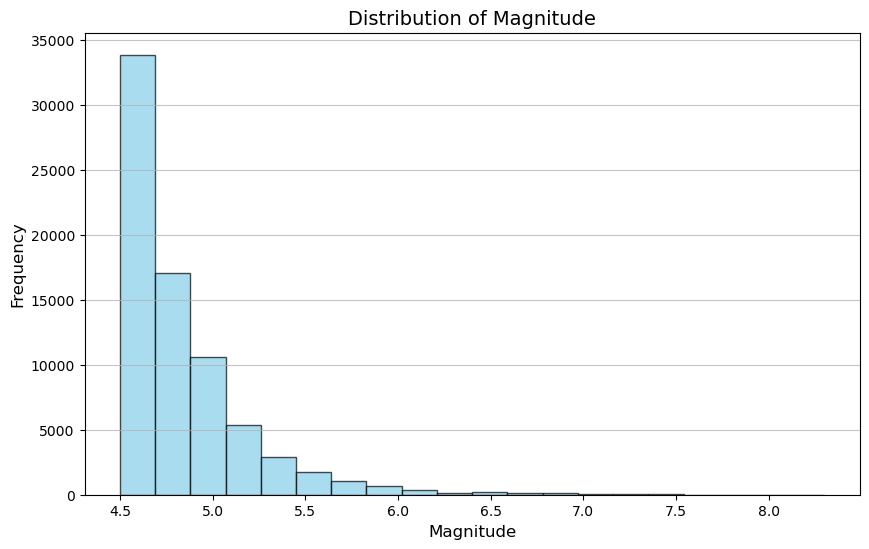

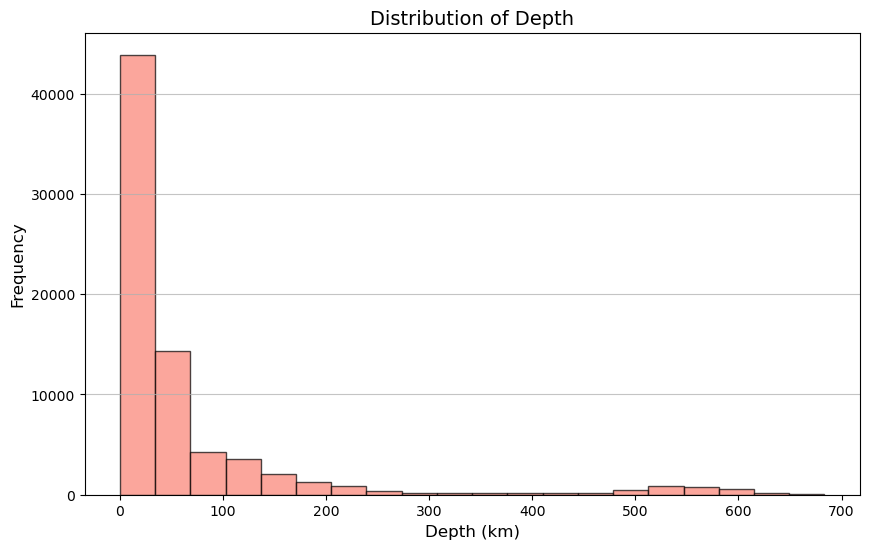

In [582]:
# Explore distributions of numeric columns
# Histogram for Magnitude
plt.figure(figsize=(10, 6))
plt.hist(earthquake_df_copy['magnitude'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Magnitude', fontsize=14)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Histogram for Depth
plt.figure(figsize=(10, 6))
plt.hist(earthquake_df_copy['depth'], bins=20, color='salmon', edgecolor='black', alpha=0.7)
plt.title('Distribution of Depth', fontsize=14)
plt.xlabel('Depth (km)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

### 3. Scatter Plot for Magnitude vs Depth
A scatter plot was created to analyze the relationships between earthquake magntude and dept. After looked at the histograms, looking at the relationship will help to see more detail of the correlation.
- There is no strong correlation was found between magnitude and dept,
- It seems that larger magnitudes tend to occur at shallower depths. 

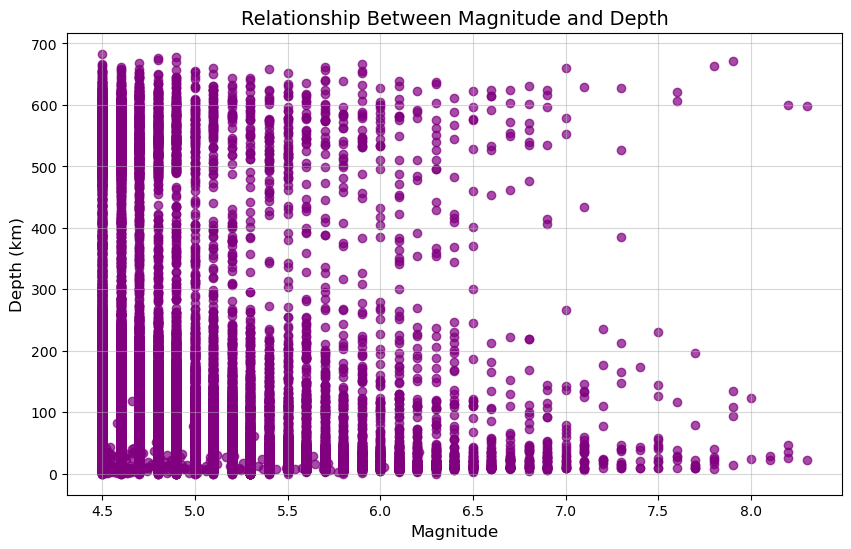

In [228]:
# Explore relationships between columns
# Scatter Plot: Magnitude vs Depth
plt.figure(figsize=(10, 6))
plt.scatter(earthquake_df_copy['magnitude'], earthquake_df_copy['depth'], alpha=0.7, color='purple')
plt.title('Relationship Between Magnitude and Depth', fontsize=14)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Depth (km)', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

### 4. Correlation Matrix
A heatmap was created to show correlations between Magnitude, Depth, and Tsunami Alert.
- Magnitude has a moderate positive correlation (0.32) with Tsunami Alert.
- Depth has a negligible correlation with Tsunami Alert.


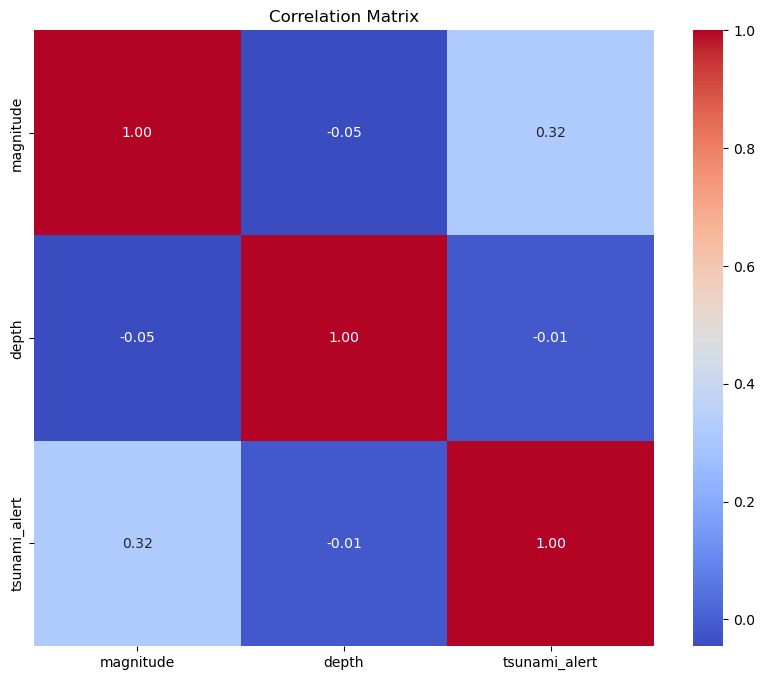

In [331]:
plt.figure(figsize=(10, 8))
corr_matrix = earthquake_df_copy[['magnitude', 'depth', 'tsunami_alert']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### 5. Pair Plot
A pair plot was created to see interaction Magnitude, Depth, and Tsunami Alert interactions.
- Found that most tsunami alerts occur at higher magnitudes and shallower depths
- The visualization clearly separates events with tsunami alerts (orange) from those without alerts (blue).


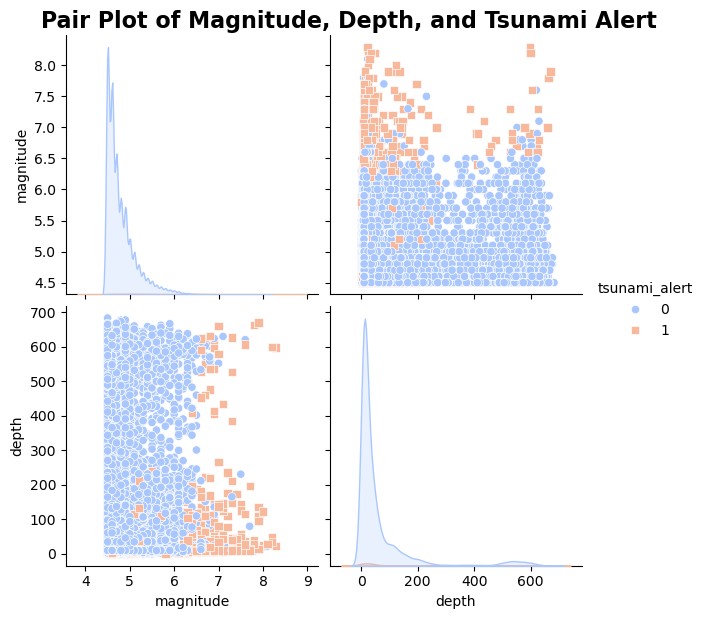

In [524]:
sns.pairplot(
    earthquake_df_copy,
    vars=['magnitude', 'depth'],
    hue='tsunami_alert',
    palette='coolwarm',
    diag_kind='kde',
    markers=['o', 's'],  
    height=3,  
)
plt.suptitle(
    "Pair Plot of Magnitude, Depth, and Tsunami Alert", 
    y=1.02, fontsize=16, fontweight='bold'
) 
plt.show()

# Step 4: Ask Questions About the Data
## The main question is "What characteristic of earthquake have an impact on tsunami alert?"
- To analyze the dataset further and answer the main question, there are seven key sub-questions, which can help to understanding of the answers:

### Sub-Question 1: Does the depth of an earthquake influence the pssibility of a tsunami alert?
1. Analysis:
    - Using depth category:
        - Shallow earthquakes: Depth < 70 km
        - Intermediate earthquakes: 70 km ≤ Depth < 300 km
        - Deep earthquakes: Depth ≥ 300 km
    - Group the data by depth category and calculate the number of tsunami alerts in each category.
2. Visualizations:
    - Bar plot: Shows the count of tsunami alerts in each depth category.
    - Boxplot: Compare depth distributions for earthquakes with and without tsunami alerts.
3. Insight:
    - Most tsunami alerts occur in the shallow earthquake category (899 alerts out of 1081 total), with very few alerts in the intermediate (151) and deep categories (31).
    - Depth influences tsunami alerts, with shallow earthquakes playing an important role to trigger tsunami.

Depth_Category
Deep earthquake             31
Intermediate earthquake    151
Shallow earthquake         899
Name: tsunami_alert, dtype: int64


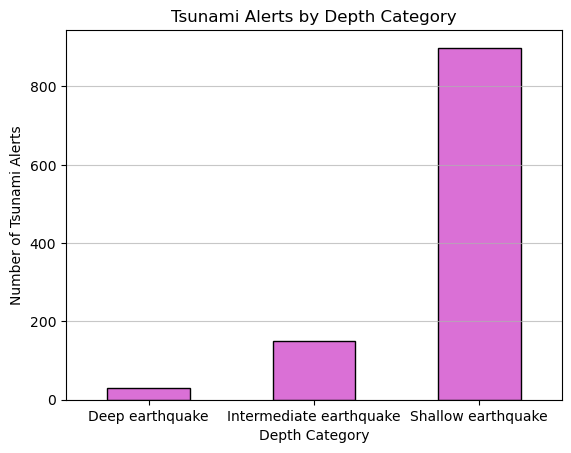

In [526]:
tsunami_by_depth = earthquake_df_copy[earthquake_df_copy['tsunami_alert'] == 1].groupby('Depth_Category')['tsunami_alert'].count()
print(tsunami_by_depth)

tsunami_by_depth.plot(kind='bar', color='orchid', edgecolor='black')
plt.title("Tsunami Alerts by Depth Category")
plt.xlabel("Depth Category")
plt.ylabel("Number of Tsunami Alerts")
plt.xticks(rotation=0) 
plt.grid(axis='y', alpha=0.7)
plt.show()

<Figure size 1000x600 with 0 Axes>

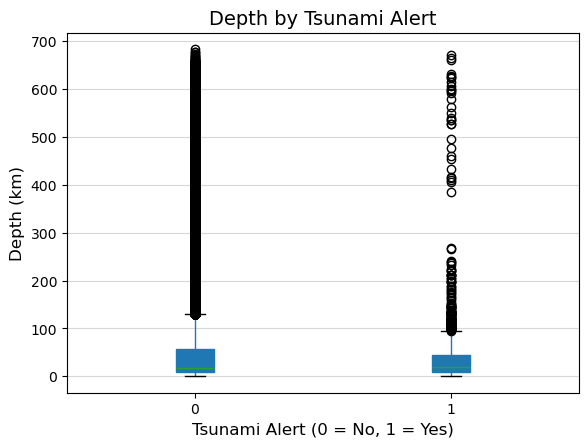

In [400]:
plt.figure(figsize=(10, 6))
earthquake_df_copy.boxplot(column='depth', by='tsunami_alert', grid=False, patch_artist=True)
plt.title('Depth by Tsunami Alert', fontsize=14)
plt.suptitle('')
plt.xlabel('Tsunami Alert (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Depth (km)', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

### Sub-Question 2: How does higher magnitude correlate with tsunami alerts?

1. Analysis:
    - Compare magnitudes of earthquakes with and without tsunami alerts using:
        - Boxplots: Compare the magnitude distribution.
        - Chi-square test: Check if magnitudes > 5.5 have a statistical significance for tsunami alerts.
2. Visualizations:
    - Boxplot: Compare magnitude with and without tsunami alerts.
    - Chi-square test result: A contingency table highlighting significance.
3. Insights:
    - Earthquakes with magnitude > 5.5 are associated with tsunami alerts, which is confirmed by a chi-square test (p-value = 0.0).


<Figure size 1000x600 with 0 Axes>

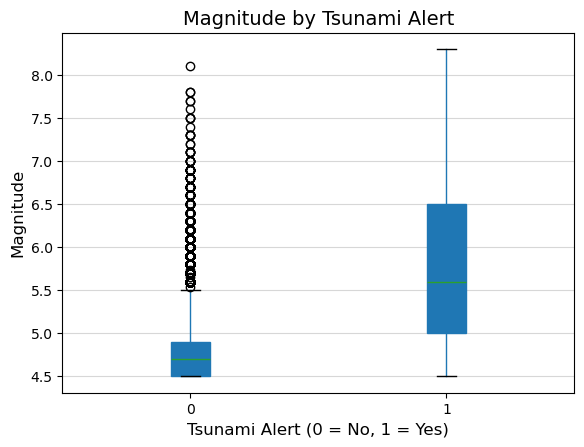

In [355]:
# Magnitude vs Tsunami Alert
plt.figure(figsize=(10, 6))
earthquake_df_copy.boxplot(column='magnitude', by='tsunami_alert', grid=False, patch_artist=True)
plt.title('Magnitude by Tsunami Alert', fontsize=14)
plt.suptitle('')
plt.xlabel('Tsunami Alert (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

In [381]:
from scipy.stats import chi2_contingency

# create Contingency Table
contingency_table = pd.crosstab(earthquake_df_copy['tsunami_alert'], earthquake_df_copy['magnitude'] > 5.5)
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Result:")
print(f"Chi-Square Statistic = {chi2}")
print(f"P-Value = {p}")

Chi-Square Test Result:
Chi-Square Statistic = 5159.02292001733
P-Value = 0.0


### Sub-Question 3: Is there a relationship between depth and magnitude?

1. Analysis:
    - From the scatter plots, found trend between depth and magnitude.
    - Use a correlation matrix to know the quantity in their relationship.
2. Visualizations:
    - Scatter plot: Shows the relationship between depth and magnitude.
    - Correlation matrix: Shows correlation coefficients.
3. Insights:
    - Depth and magnitude have a weak negative correlation, can suggest that there is no strong relationship.

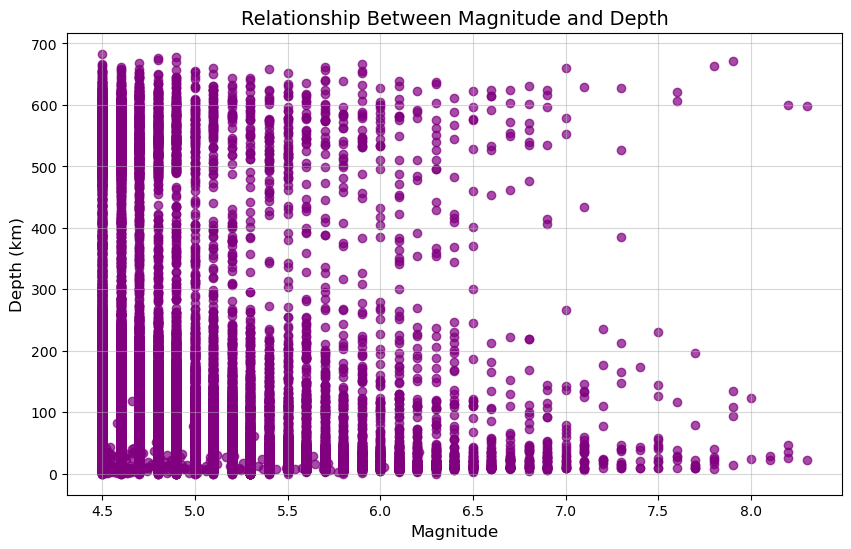

In [365]:
# Explore relationships between columns
# Scatter Plot: Magnitude vs Depth
plt.figure(figsize=(10, 6))
plt.scatter(earthquake_df_copy['magnitude'], earthquake_df_copy['depth'], alpha=0.7, color='purple')
plt.title('Relationship Between Magnitude and Depth', fontsize=14)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Depth (km)', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

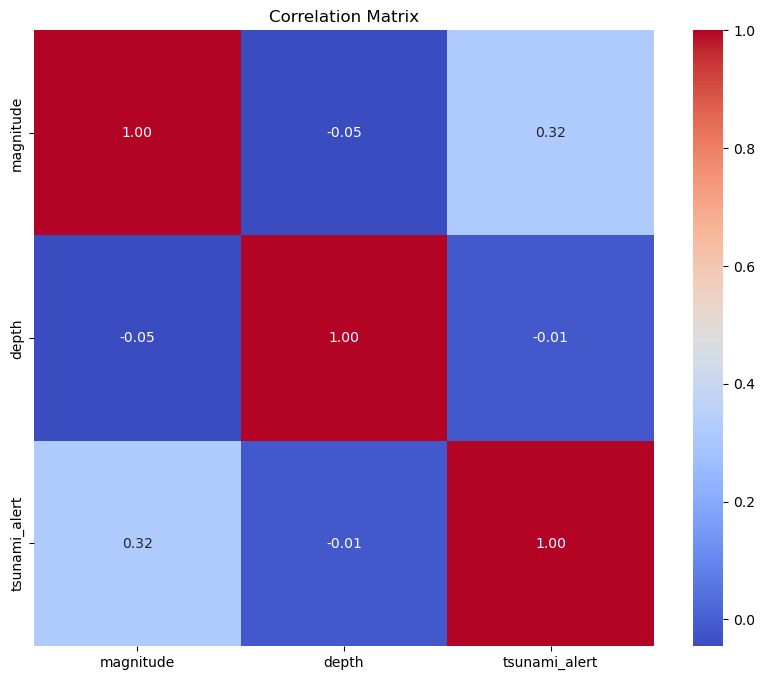

In [402]:
plt.figure(figsize=(10, 8))
corr_matrix = earthquake_df_copy[['magnitude', 'depth', 'tsunami_alert']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Sub-Question 4: How are tsunami alerts distributed across depth categories?

1. Analysis:
    - Count the number of tsunami alerts in each depth category.
    - Visualize the counts by using a bar plot.
    - Use box plot to analyze the magnitude distribution of earthquakes that triggered tsunami alerts cover different depth categories.
2. Visualizations:
    - Bar plot: Number of tsunami alerts by depth category.
    - Box Plot: Distribution of magnitude by dept category.
3. Insights:
    - Shallow earthquake have an strong impct on tsunami alerts, while having fewer alerts from intermediate and deep earthquakes.
    - Shallow earthquakes that triggered tsunami alerts typically have lower magnitudes compared to intermediate and deep earthquakes.
    - Intermediate earthquakes tend to have a wider magnitude range, while deep earthquakes have higher magnitudes in the data.

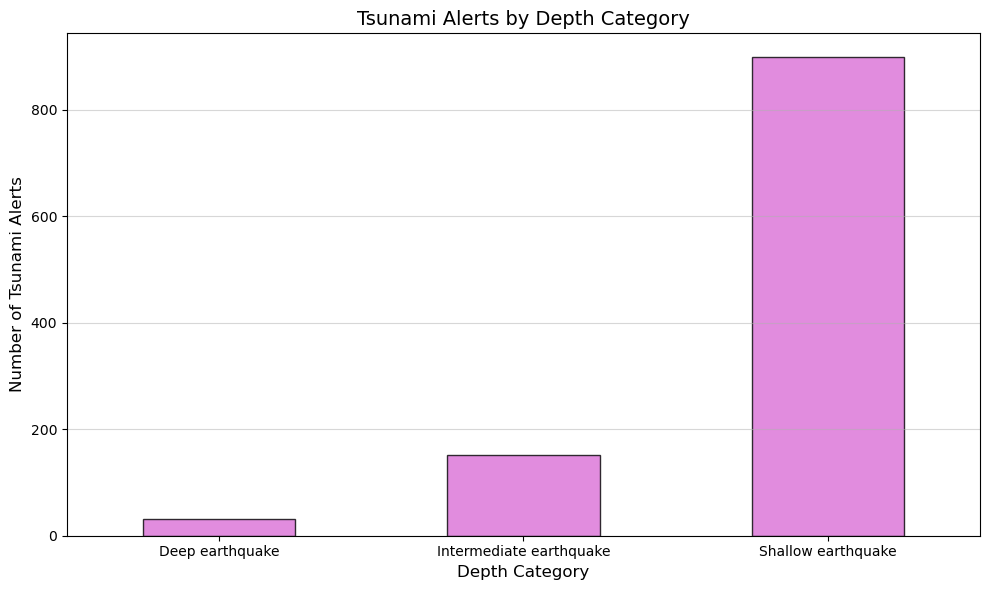

In [369]:
# Plot tsunami alerts by depth category
plt.figure(figsize=(10, 6))
tsunami_alerts_by_depth.plot(kind='bar', color='orchid', alpha=0.8, edgecolor='black')
plt.title('Tsunami Alerts by Depth Category', fontsize=14)
plt.xlabel('Depth Category', fontsize=12)
plt.ylabel('Number of Tsunami Alerts', fontsize=12)
plt.xticks(rotation=0)  # เอียง Label 45 องศา
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()  # ทำให้กราฟไม่ทับกับ Label
plt.show()

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_12539/3492939866.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depth_Category', y='magnitude', data=tsunami_data, palette='pastel')


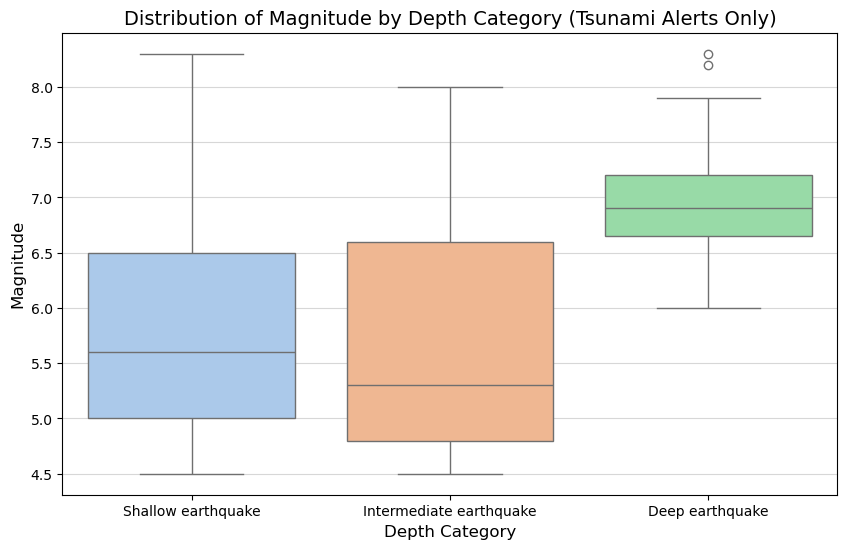

In [438]:
# Filter only tsunami alerts
tsunami_data = earthquake_df_copy[earthquake_df_copy['tsunami_alert'] == 1]

# Boxplot for Magnitude by Depth Category
plt.figure(figsize=(10, 6))
sns.boxplot(x='Depth_Category', y='magnitude', data=tsunami_data, palette='pastel')
plt.title('Distribution of Magnitude by Depth Category (Tsunami Alerts Only)', fontsize=14)
plt.xlabel('Depth Category', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

### Sub-Question 5: What are the correlations between magnitude, depth, and tsunami alerts?

1. Analysis:
    - Calculate the correlation matrix for magnitude, depth, and tsunami alerts.
2. Visualizations:
    - Correlation heatmap.
3. Insights:
    - Magnitude have a positive correlattion with tsunami alerts (moderate correlation: 0.32).
    - Depth has a very weak correlation with tsunami alerts (-0.01).
    - Magnitude and dept have no direct relationship (-0.05).

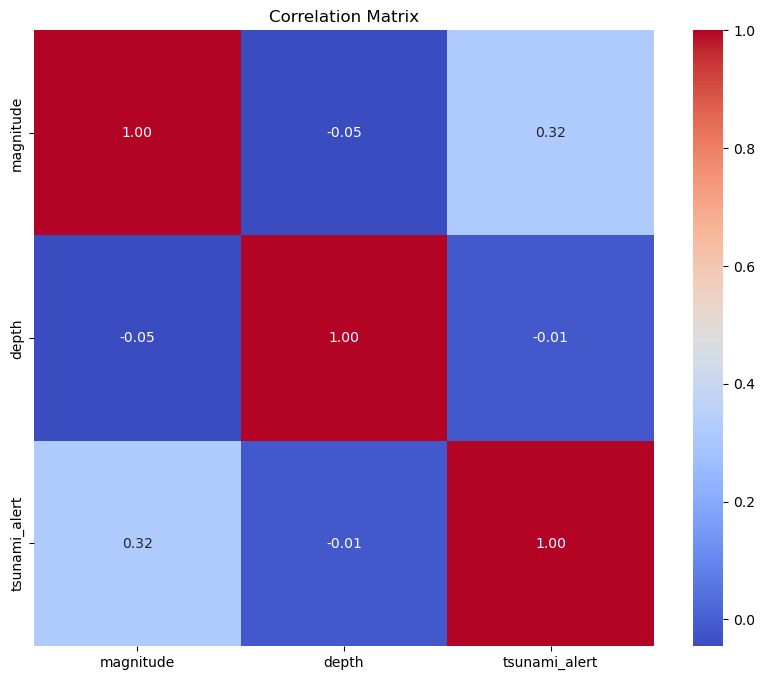

In [372]:
plt.figure(figsize=(10, 8))
corr_matrix = earthquake_df_copy[['magnitude', 'depth', 'tsunami_alert']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Sub-Question 6: How do magnitude and depth distributions differ for earthquakes that trigger tsunami alerts versus those that do not?

1. Analysis:
    - Separate data into two groups: with and without tsunami alerts.
    - Compare distributions of magnitude and depth using:
        - Histograms: Frequency distributions 
        - Boxplots: Summary statistics for both groups.
2. Visualizations:
    - Histograms: Show magnitude and depth distributions. 
    - Boxplots: Compare magnitude and depth for the two groups.
4. Insights:
    - Earthquakes with tsunami alerts tend to have higher magnitudes (> 5.5) and occur in shallower depths.
    - Non-tsunami earthquakes show broader distributions.

<Figure size 1000x600 with 0 Axes>

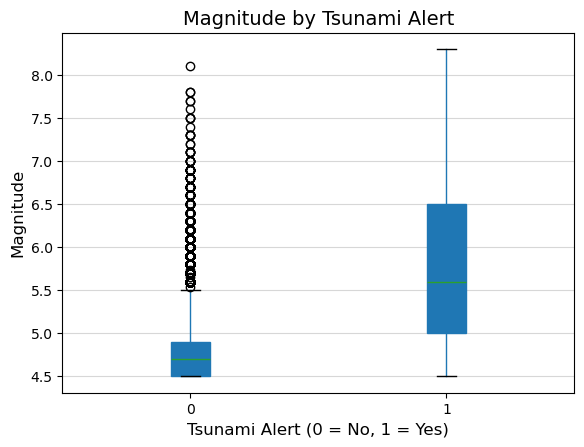

<Figure size 1000x600 with 0 Axes>

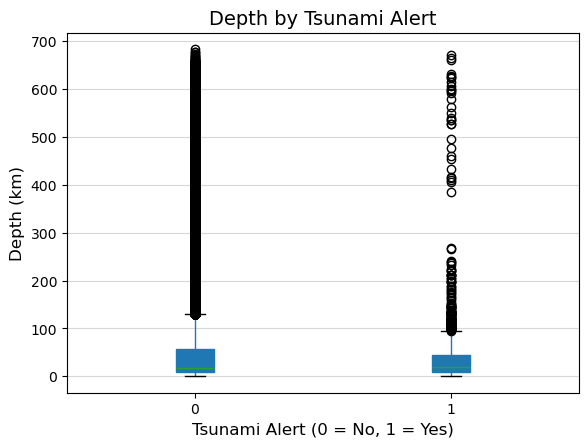

In [357]:
# Magnitude vs Tsunami Alert
plt.figure(figsize=(10, 6))
earthquake_df_copy.boxplot(column='magnitude', by='tsunami_alert', grid=False, patch_artist=True)
plt.title('Magnitude by Tsunami Alert', fontsize=14)
plt.suptitle('')
plt.xlabel('Tsunami Alert (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

# Depth vs Tsunami Alert
plt.figure(figsize=(10, 6))
earthquake_df_copy.boxplot(column='depth', by='tsunami_alert', grid=False, patch_artist=True)
plt.title('Depth by Tsunami Alert', fontsize=14)
plt.suptitle('')
plt.xlabel('Tsunami Alert (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Depth (km)', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

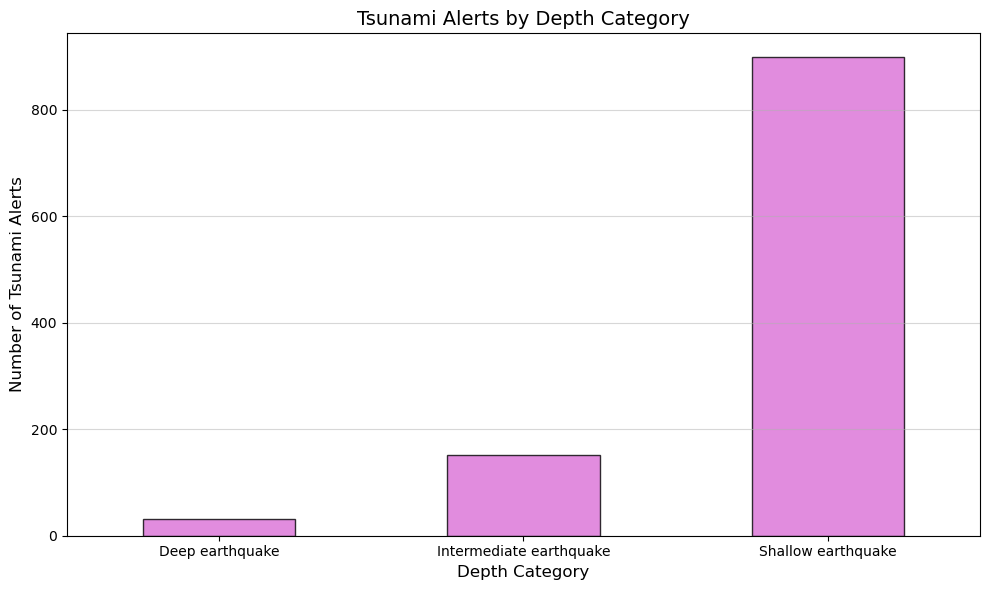

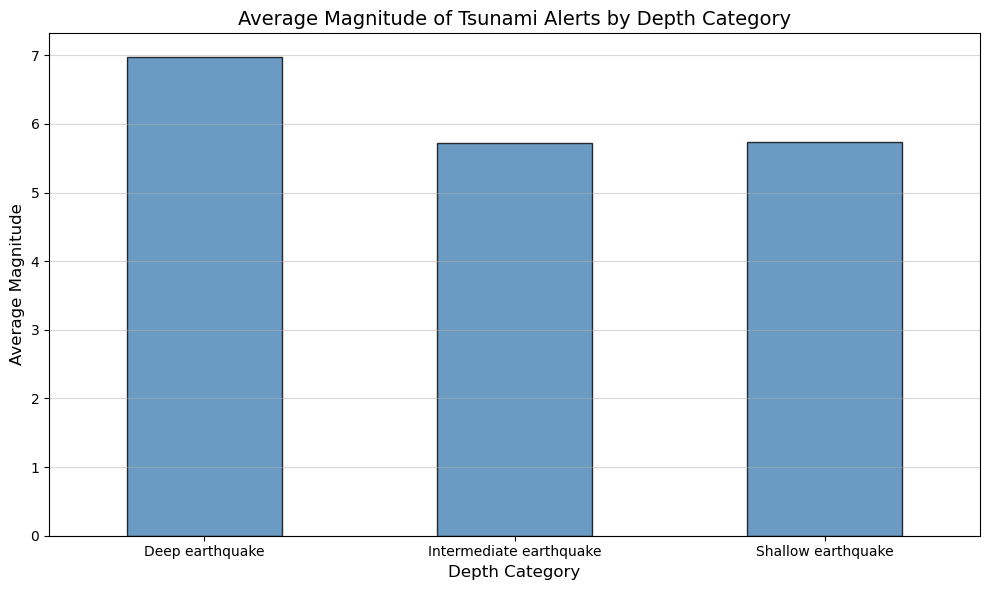

In [317]:
# Plot tsunami alerts by depth category
plt.figure(figsize=(10, 6))
tsunami_alerts_by_depth.plot(kind='bar', color='orchid', alpha=0.8, edgecolor='black')
plt.title('Tsunami Alerts by Depth Category', fontsize=14)
plt.xlabel('Depth Category', fontsize=12)
plt.ylabel('Number of Tsunami Alerts', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot average magnitude for tsunami alerts by depth category
plt.figure(figsize=(10, 6))
avg_magnitude_by_depth.plot(kind='bar', color='steelblue', alpha=0.8, edgecolor='black')
plt.title('Average Magnitude of Tsunami Alerts by Depth Category', fontsize=14)
plt.xlabel('Depth Category', fontsize=12)
plt.ylabel('Average Magnitude', fontsize=12)
plt.xticks(rotation=0)  
plt.grid(axis='y', alpha=0.5)
plt.tight_layout() 
plt.show()

### Sub-Question 7: What are the unique characteristics of shallow earthquakes?

1. Analysis:
    - Filter data for shallow earthquakes.
    - Use boxplots to compare the magnitude distributions for shallow earthquakes with and without tsunami alerts.
2. Visualizations:
    - Boxplot: Magnitude of shallow earthquakes by tsunami alert.
3. Insights:
    - Among shallow earthquakes, those with tsunami alerts tend to have higher magnitudes. This shows that both shallow depth and high magnitude are critical factors.

<Figure size 1000x600 with 0 Axes>

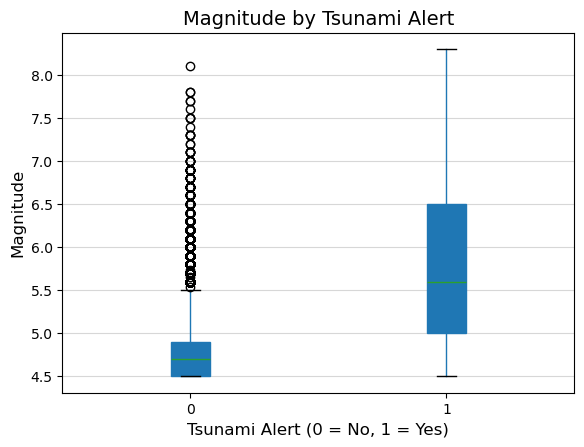

In [409]:
# Magnitude vs Tsunami Alert
plt.figure(figsize=(10, 6))
earthquake_df_copy.boxplot(column='magnitude', by='tsunami_alert', grid=False, patch_artist=True)
plt.title('Magnitude by Tsunami Alert', fontsize=14)
plt.suptitle('')
plt.xlabel('Tsunami Alert (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

# Step 5: Summarize and conclusion

## Summary:
The earthquake characteristics that have an impact on tsunami alert including:

1. Shallow Depth (< 70 km):
    - Earthquakes with depths less than 70 km are most likely to trigger tsunami alerts. These are referred to shallow earthquakes.
    - Shallow earthquakes tend to generate significant energy that reaches the ocean floor, increasing the probability of tsunami formation.

2. Magnitude (> 5.5):
    - Earthquakes that have magnitudes above 5.5 are more likely to trigger tsunami alerts. This is because higher-magnitude earthquakes release more energy, causing greater displacement of water when occurring in shallow regions.

3. Lack of Relationship Between Depth and Magnitude:
    - From the analysis, there is no significant direct correlation between an earthquake's depth and its magnitude. For example, both high and low magnitude earthquakes can occur at various depths, this can suggest that depth and magnitude are independent variables.

4. Depth and Magnitude’s Roles in Tsunami Alerts:
    - Shallow Depth:
        - Shallow earthquakes play a significant role in tsunami alerts.
    - Higher Magnitude:
        - Higher magnitude can trigger tsunami alert, but have to occur with the dept that less than 70 km (Shallow Earthquake)
## Conclusion:
- This analysis found that Shallow dept is the most significant that trigger tsunami alert because they disturb the ocean floor more directly, while magnitude is the factor that increase the possibility to trigger tsunami. However, the higher magnitude does not comfirm to trigger tsunami if it occur in deep earthquake. This explains why depth is a critical factor in tsunami generation. Finally, this analysis enhances the understanding of the factor that have the correlation with tsunami generation, which can be used to improve ability to warn when tsunami occur. This can lead to reduce the effect of life of our population in the future

## Future Work Suggestions:

This analysis merely focuses on depth and magnitude. Future studies could improve prediction accuracy by including additional earthquake characteristics:

1. Geographic Location:
    - Certain regions, such as subduction zones near tectonic plate boundaries, are more pssible to trigger tsunami.

2. Plate Tectonics:
Understanding the type and motion of tectonic plates (e.g., subduction vs. strike-slip) could provide more context.

3. Water Displacement:
Including measurements of water displacement during an earthquake can directly connect seismic activity to tsunami risks.

4. Apply Machine Learning Models:
    - For predicting tsunami alerts using machine learning may enhance accuracy and reduce false positives. For example,
using algorithms like Logistic Regression to classify earthquakes based on their pssible of triggering tsunamis. Additionally, training models with global datasets that include richer features, such as seismic waveforms, duration of shaking, and aftershock patterns.